In [1]:
import numpy as np
import networkx as nx
#from hungarian_algorithm import algorithm
import matplotlib.pyplot as plt
import time
from scipy.optimize import linear_sum_assignment
from sklearn.feature_extraction import DictVectorizer
import itertools #changed

import osmnx as ox
import requests

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.2'

# Todo
### 1. Add dijkstra shortest path based on traffic!
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path.html
### 2. Import open street map to networkx
Import map from openstreetmap https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873
### Connect networkx with SUMO 
https://easychair.org/publications/open/Bwmq

DegreeView({0: 2, 1: 3, 2: 3, 3: 2, 4: 3, 5: 4, 6: 4, 7: 3, 8: 3, 9: 4, 10: 4, 11: 3, 12: 2, 13: 3, 14: 3, 15: 2})

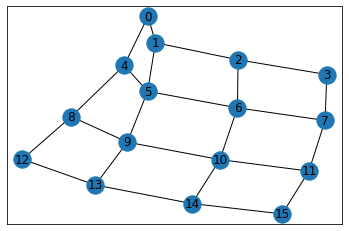

In [2]:
# Number of locations in the city
# Import map from openstreetmap https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
n = 4
N = n*n
total_taxis = N*10
connectivity = 5
p = 0.8
traffic_jam_variable=1 # Använd denna i simulationen för att sakta ner hastigheterna på vägarna. 
max_travel_length=1
# make a random graph to represent a city network
#road_network = nx.connected_watts_strogatz_graph(N, connectivity, p)
#nodes = road_network.nodes
# Make a circular city
road_network = nx.grid_graph([n,n])
#shells = [[2, 3, 4, 5, 6], [8, 1, 0, 19, 18, 17, 16, 15, 14, 7], [9, 10, 11, 12, 13]]
road_network = nx.convert_node_labels_to_integers(road_network, first_label=0, ordering="default", label_attribute=None)
road_network = road_network.to_undirected()
nodes = road_network.nodes
#road_network.remove_node(0)
N = len(nodes)
nx.draw_networkx(road_network)

plt.savefig('Nodes_16')
road_network.degree

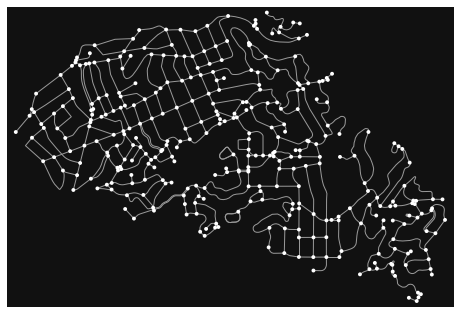

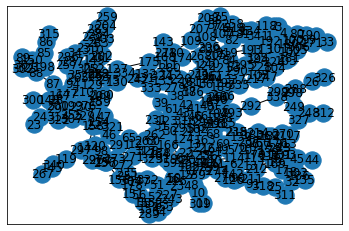

In [3]:
# get a graph for some city
road_network = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
road_network = nx.convert_node_labels_to_integers(road_network, first_label=0, ordering="default", label_attribute=None)
road_network = road_network.to_undirected()
nodes = road_network.nodes
N = len(nodes)
fig, ax = ox.plot_graph(road_network)
nx.draw_networkx(road_network)

In [4]:
nx.shortest_path(road_network, 1,2)

[1, 2]

In [5]:
class Taxi:
    """
    A taxi class to keep track of the internal state for each taxi.
    """
    def __init__(self, number, start_location):
        self._number = number
        self.available = True
        self.rebalance = True
        self.current_location = start_location
        #self.sources = [] #TODO ska denna tas bort? den används ej
        self.destinations = []
        self.sources = []
        self.paths = iter([]) #changed
        self.paths_list = [] 
        self.path_generator = None #changed
        self.expected_reward = 0.
        self.customer_wait_time = None
        self.to_customer = False
        self.to_destination = False
        self.total_path = []

    @property
    def number(self):
        return self._number

    def hire(self, source, destination):
        #changed>
        #self.sources.append(source)
        if not self.destinations:
            self.sources.append(source)
            self.destinations.append(destination)
            self.set_path_and_reward(source, destination)
            self.rebalance = False
            self.to_customer = True
        else:
            self.add_path_to_current_path(source,destination)
            self.destinations.append(destination)
            self.sources.append(source)
            self.rebalance = False
            
        # if self.available == True:
        #     self.available = False
        #     self.source=source 
        #     self.destination=destination 
        #     self.set_path_and_reward(source, destination)
        #changed<
            
    def set_path_and_reward(self, source, destination):
        """
        Sets a path from current location to source and then the destination.
        
        """
        path_to_customer = nx.shortest_path(road_network, self.current_location,
                                       source)
        path_to_destination = nx.shortest_path(road_network, source,
                                       destination)
        
        self.total_path = path_to_customer+path_to_destination[1:]
        
        self.paths = itertools.chain(self.paths,self.total_path) #changed
        self.paths_list = self.paths_list + self.total_path 
        #self.path_generator = (p for p in total_path) #changed
        cost_to_go_to_customer = len(path_to_customer)
        trip_reward = 3*len(path_to_destination)
        
        self.expected_reward = trip_reward - cost_to_go_to_customer
        self.customer_wait_time = len(path_to_customer)
    def add_path_to_current_path(self,source,destination):
        """
        Sets a path from final previous destination location to source and then the new final destination.
        
        """
        path_to_customer = nx.shortest_path(road_network, self.destinations[-1],
                                       source)
        path_to_destination = nx.shortest_path(road_network, source,
                                       destination)
        
        self.total_path = path_to_customer[1:]+path_to_destination[1:]
        
        self.paths = itertools.chain(self.paths,self.total_path) #changed
        self.paths_list = self.paths_list + self.total_path 
        
        #self.path_generator = (p for p in total_path) #changed
        cost_to_go_to_customer = len(path_to_customer)
        trip_reward = 3*len(path_to_destination)
        
        self.expected_reward = trip_reward - cost_to_go_to_customer
        self.customer_wait_time = len(path_to_customer)

    def get_cost_of_action(self,source,destination):
        if len(self.destinations)>0:
            try: 
                path_to_customer = nx.shortest_path(road_network, self.destinations[-1],
                                               source)
            except nx.NetworkXNoPath:
                print('No path')
        else:
            path_to_customer = nx.shortest_path(road_network, self.current_location,
                                           source)
        
        #finish_current_action=[]
        #if not self.available:
        #    finish_current_action = nx.shortest_path(road_network,self.current_location,self.destinations[0])#changed
        # TODO fix this so length of path is accunted for
        #path_to_destination = nx.shortest_path(road_network, source,destination)
                                       
        total_cost = len(path_to_customer)+len(self.paths_list)
        return total_cost

    def step(self):
        #changed
        #print('location',self.current_location)
        self.current_location = next(self.paths,self.current_location)
        #print('location',self.current_location)
        if self.paths_list:
            del self.paths_list[0]
        if self.to_customer and self.sources:
            if self.current_location == self.sources[0]:
                del self.sources[0]
                self.to_customer = False
                self.to_destination = True
        elif self.to_destination and self.destinations:
            if self.current_location == self.destinations[0]:
                del self.destinations[0]
                self.to_destination = False 
                if len(self.sources)>0:
                    self.to_customer = True
                else:
                    self.available = True
                    self.rebalance = True
        elif not self.rebalance:
            if self.current_location == self.destinations[0]:
                del self.destinations[0]
                self.rebalance = True

    def rebalancing(self,destination):
        # Rebalance taxi from current location to destination
        #print('Taxi: ',self.number,'Path: ', self.paths_list)
        self.destinations.append(destination)
        self.set_path_and_reward(self.current_location, destination)
        #print('Taxi: ',self.number,'Path: ', self.paths_list)
        self.rebalance = False
                                          
                                          
                    
    def __repr__(self):
        return str(self.number)

# Set taxi at location 5
taxi_test = Taxi(0, 1)

# Hire for a delivery from location
#taxi_test.hire(2, 5)

print("Total path to travel", taxi_test.paths)
print("Total expected reward", taxi_test.expected_reward)
print("Total customer wait time", taxi_test.customer_wait_time)
print('to customer',taxi_test.to_customer)
# Take a few steps
for i in range(30):
    print('iteration:',i)
    taxi_test.step()
    print('path',taxi_test.paths_list)
    print('destination',taxi_test.destinations)
    print('Cost: ',taxi_test.get_cost_of_action(1,2))
    if i == 2:
        print('Hire')
        taxi_test.hire(0,2)
    if i == 10:
        taxi_test.hire(2,1)
    if i == 17:
        taxi_test.rebalancing(2)
        
    print("Location: ", taxi_test.current_location,', Available: ',taxi_test.rebalance,', Destinations',taxi_test.destinations)


Total path to travel <list_iterator object at 0x166919460>
Total expected reward 0.0
Total customer wait time None
to customer False
iteration: 0
path []
destination []
Cost:  1
Location:  1 , Available:  True , Destinations []
iteration: 1
path []
destination []
Cost:  1
Location:  1 , Available:  True , Destinations []
iteration: 2
path []
destination []
Cost:  1
Hire
Location:  1 , Available:  False , Destinations [2]
iteration: 3
path [172, 99, 0, 99, 172, 1, 2]
destination [2]
Cost:  9
Location:  1 , Available:  False , Destinations [2]
iteration: 4
path [99, 0, 99, 172, 1, 2]
destination [2]
Cost:  8
Location:  172 , Available:  False , Destinations [2]
iteration: 5
path [0, 99, 172, 1, 2]
destination [2]
Cost:  7
Location:  99 , Available:  False , Destinations [2]
iteration: 6
path [99, 172, 1, 2]
destination [2]
Cost:  6
Location:  0 , Available:  False , Destinations [2]
iteration: 7
path [172, 1, 2]
destination [2]
Cost:  5
Location:  99 , Available:  False , Destinations [2

In [6]:
 #nx.shortest_path(road_network,326,0)
road_network.has_edge(326,0)

False

In [7]:
taxi_queue = [[] for i in range(N)]

taxi_list = list(range(total_taxis))

for i in range(total_taxis):
    rand_location = np.random.randint(0, N)
    taxi_queue[rand_location].append(Taxi(i, rand_location)) #TODO kolla så att inte taxi_queue[rand_location] är populerad
    taxi_list[i] = Taxi(i, rand_location)

In [8]:
def generate_demand(queue,queue_wait_time,lam1,lam2):
    """
    Generates demands to go randomly to new locations at each point and adds to queue.
    
    Args:
        queue (list): a list of current demands at each location
    """
    connections = road_network.degree
    for i in range(N):
        con = connections[i]
        if con>=4:
            demand = np.random.poisson(lam = np.random.uniform(lam1[0],lam1[1]))
        else:
            demand = np.random.poisson(lam = np.random.uniform(lam2[0],lam2[1]))
        
        possible_destinations = list(nodes)
        possible_destinations.remove(i)
        new_destinations = np.random.choice(possible_destinations, demand)
        [queue[i].append(d) for d in new_destinations.ravel()] 
        [queue_wait_time[i].append(0) for d in new_destinations.ravel()] 
#    for i, demand in enumerate(np.random.poisson(lam = np.random.uniform(lam1,lam2),size=N)):
#        possible_destinations = list(nodes)
#        possible_destinations.remove(i)
#        new_destinations = np.random.choice(possible_destinations, demand)
#        [queue[i].append(d) for d in new_destinations.ravel()]  #TODO svårläst skriv så här:
        # for d in new_destinations.ravel():
        #     queue[i].append(d)
    return queue,queue_wait_time

In [9]:
queue = [[] for i in range(N)]
queue_wait_time = [[] for i in range(N)]
queue,queue_wait_time = generate_demand(queue,queue_wait_time,[0,1],[7,8])
print(queue)
print(queue_wait_time)
print(queue_wait_time)

[[219, 65, 252, 107, 276, 184], [5, 302, 0, 18, 260, 319, 155, 320], [0, 315, 133, 161, 50, 218, 124], [213, 8, 205, 306, 74, 143, 126], [193, 132, 52, 326, 134, 133, 143], [78, 159, 110, 269, 211, 280, 75, 83, 71, 159], [21, 273, 329, 136, 59, 159, 247], [], [], [244, 309, 50, 333, 20, 209, 212, 275, 213, 217, 71], [326, 337, 181, 41, 0, 147, 185, 81, 129, 235], [59, 127, 293, 327, 185, 297, 213, 115], [93, 163, 63, 298, 286], [255, 181, 298, 66], [281, 129, 102, 150], [197, 175, 326, 156, 277, 265, 79], [40, 331, 290, 341, 37, 167], [191, 278, 226, 54, 40, 311, 255, 36, 157, 174], [28, 270, 98, 153], [252], [194, 241, 49], [277, 134, 97, 17, 184, 224, 309, 341, 43, 282, 238], [103, 169, 289, 21, 266, 33], [330, 49, 68, 61, 72, 92, 116, 184], [76, 288, 152, 168, 129, 149], [258], [145, 174, 145, 332, 121, 248, 121, 164, 117], [45, 311, 239, 288, 144, 72, 106, 34, 256], [75, 73, 59, 45, 162], [35], [75, 7, 241, 197, 88, 225], [292, 107, 283, 202, 179], [340, 10, 297, 46, 93, 72, 115], 

In [10]:
def assign(actions, taxi_queue):
    """
    Assign the actions to the taxis
    """
    for i, action in enumerate(actions):
        for k in range(len(action)):
            # random destination
            dest = np.random.randint(0, N)
            taxi_queue[i][k].hire(action[k], dest)
    return taxi_queue

In [11]:
def take_step():
    """
    """
    taxi_queue = [[] for i in range(N)]
    for taxi in taxi_list:
        taxi.step()
        #print(taxi.number,':',taxi.current_location)
        taxi_queue[taxi.current_location].append(taxi)
        #print(taxi_queue)
    #print(taxi_queue) 
    return taxi_queue

In [12]:
def make_to_int(id):
    return int(id[1])
def Bipartite_graph():
    all_possible_actions=[]
    for i,node in enumerate(range(N)):
        for dest in queue[i]:
            action_id='{0}TO{1}'.format(node,dest)
            all_possible_actions.append(action_id)
    H={taxi:{} for taxi in range(total_taxis)}
    HMatrix = np.zeros((total_taxis,len(all_possible_actions)))
    for taxi in taxi_list:
        for index,action_id in enumerate(all_possible_actions):
            source,destination= map(int,action_id.split('TO'))
            #print(taxi.number)
            H[taxi.number][action_id]=taxi.get_cost_of_action(source,destination)
            HMatrix[taxi.number][index] = taxi.get_cost_of_action(source,destination)
    return HMatrix,all_possible_actions


In [13]:
def hungarian(HMatrix,all_possible_actions): #CHANGED input aLL_possible_actions
    
    time_start = time.time()

    taxis,request = linear_sum_assignment(HMatrix)
    #algorithm.find_matching(H, matching_type = 'min', return_type = 'list')
    time_elapsed = (time.time() - time_start)
    #print('Time: ', time_elapsed)
    # changed >
    actions_to_assign={}
    for i,taxi in enumerate(taxis):
        actions_to_assign[taxi]=all_possible_actions[request[i]]
    return actions_to_assign
    

In [14]:
def remove_from_queue(actions_to_assign):

    for taxi in actions_to_assign:
        action_id = actions_to_assign[taxi]
        source,destination = map(int,action_id.split('TO'))
        queue_idx_of_dest = queue[source].index(destination)
        #print(source,queue_idx_of_dest)
        #print(queue[source][queue_idx_of_dest])
        del queue[source][queue_idx_of_dest]
        
#HMatrix,all_possible_actions = Bipartite_graph()
#actions_to_assign = hungarian(HMatrix,all_possible_actions)
#print(actions_to_assign)
#print(queue)
#remove_from_queue(actions_to_assign)
#print(queue)
#for taxi in actions_to_assign:
#    print(taxi)

In [15]:
def rebalance_taxis(number_stations,imbalance):

    for i in range(number_stations):
        stations_with_more_taxis = imbalance<0
        procent_taxi_rebalance = 0.6
        count = 0
        imbalance_difference = np.zeros((N,N))
        ind = np.zeros(2)
        for i in range(N):
            for j in range(N):
                imbalance_difference[i][j] = imbalance[i]-imbalance[j]
        if min(imbalance)<0:
            #rebalance
            ind = np.unravel_index(np.argmax(imbalance_difference, axis=None), imbalance_difference.shape)
            # Rebalance from ind[1] to ind [0]
            for taxi in taxi_queue[ind[1]]:
                #n_taxis = len(taxi_queue[ind[1]])
                
                if count<abs(imbalance[ind[1]])*procent_taxi_rebalance:
                    if taxi.rebalance:
                        taxi.rebalancing(ind[0])
                        #print('Rebalance from: ',ind[1],'To: ', ind[0])
                        count += 1
                else:
                    break
        else:
            #No rebalance
            break
        #print('Rebalance from: ',ind[1],'To: ', ind[0])
        #print('Imbalance: ',imbalance[ind[0]])
        #print('Imbalance: ',imbalance[ind[1]])
        imbalance[ind[0]] -= count
        imbalance[ind[1]] += count
        #print('Imbalance: ',imbalance[ind[0]],'count+: ',count)
        #print('Imbalance: ',imbalance[ind[1]],'count-: ',count)
    return imbalance_difference

In [16]:
def init(total_taxis,lam1,lam2):
    taxi_queue = [[] for i in range(N)]
    #taxi_list = list(range(total_taxis))
    for i in range(total_taxis):
        rand_location = np.random.randint(0, N-1)
        taxi_queue[rand_location].append(taxi_list[i])
    # Create request
    queue = [[] for i in range(N)]
    queue_wait_time = [[] for i in range(N)]
    queue,queue_wait_time = generate_demand(queue,queue_wait_time,lam1,lam2)
    return queue,taxi_queue
def simulation(queue,taxi_queue,taxi_list,lam1,lam2,max_cost):
    HMatrix,all_possible_actions = Bipartite_graph()
    cost_nodes_now = np.zeros((1,N))
    #u, s, vh = np.linalg.svd(HMatrix)
    #print('u: ',u,'s:',s,'vh: ',vh)
    actions_to_assign = hungarian(HMatrix,all_possible_actions)
    actions_to_remove = actions_to_assign.copy()
    for taxi in actions_to_assign:
        #print(taxi)
        action_id=actions_to_assign[taxi]
        source,destination= map(int,action_id.split('TO'))
        cost = taxi_list[taxi].get_cost_of_action(source,destination)
        if cost<max_cost:
            #print('Cost: ',cost,'action_id',action_id,'location',taxi_list[taxi].current_location)
            taxi_list[taxi].hire(source,destination)
            cost_nodes_now[0][source] += cost
            #print(actions_to_assign)
        else:
            #print('Cost: ',cost,'Action: ',actions_to_remove[taxi],'Taxi location:',taxi_list[taxi].current_location)
            del actions_to_remove[taxi]
    
    remove_from_queue(actions_to_remove)
    for i in range(N):
        cost_nodes_now[0][i] += len(queue[i])
    taxi_queue = take_step()
    generate_demand(queue,queue_wait_time,lam1,lam2)
    return taxi_queue,cost_nodes_now

    

In [17]:
connections = road_network.degree
lam1 = [5,5]
lam2 = [2,2]
queue, taxi_queue = init(total_taxis,lam1,lam2)
number_stations_to_rebalance = N
time_steps = 100
max_cost = 4
taxis_time = np.zeros((time_steps,N))
requests_time = np.zeros((time_steps,N))
imbalance = np.zeros((time_steps,N))
pick_up_time = np.zeros((time_steps,N))
available_taxis = np.zeros((time_steps,N))
cost_nodes = np.zeros((time_steps,N))
for i in range(time_steps):
    taxi_queue,cost_nodes_now = simulation(queue,taxi_queue,taxi_list,lam1,lam2,max_cost)
    cost_nodes[i][:] = cost_nodes_now
    #print('TAXI_QUEUE: ',taxi_queue)
    for j in range(N):
        taxis_time[i][j] = len(taxi_queue[j])
        requests_time[i][j] = len(queue[j])
        imbalance[i][j] = len(queue[j])
        for taxi in taxi_queue[j]:
            
            if taxi.rebalance:
                imbalance[i][j] -= 1
                available_taxis[i][j] += 1
    rebalance_taxis(number_stations_to_rebalance,imbalance[i])


KeyboardInterrupt: 

Total cost:  42476.0
Total imbalance 50119.0


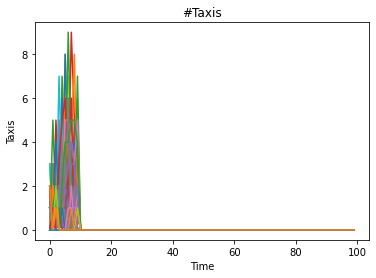

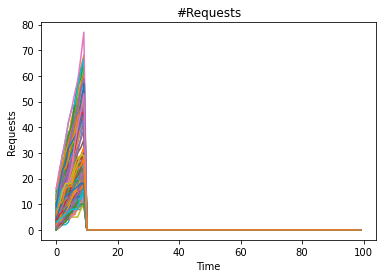

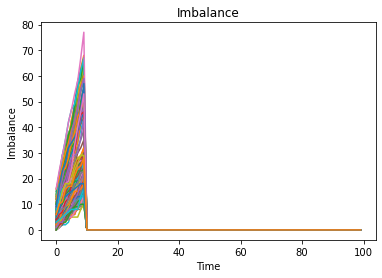

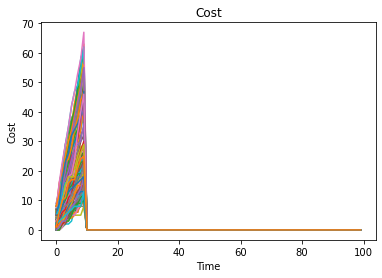

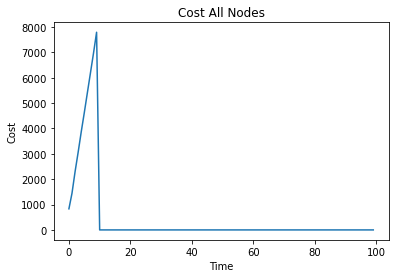

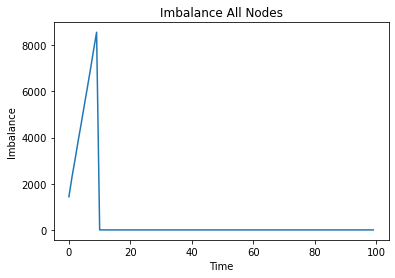

In [18]:
plt.figure(1)
plt.plot(taxis_time)
plt.xlabel('Time')
plt.ylabel('Taxis')
plt.title('#Taxis')
plt.figure(2)
plt.plot(requests_time)
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('#Requests')
plt.figure(3)
plt.plot(imbalance)
plt.xlabel('Time')
plt.ylabel('Imbalance')
plt.title('Imbalance')
plt.figure(4)
plt.plot(cost_nodes)
plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Cost')
plt.figure(5)
plt.plot(np.sum(cost_nodes, axis=1))
plt.xlabel('Time')
plt.ylabel('Cost')
plt.title('Cost All Nodes')
plt.figure(6)
plt.plot(np.sum(imbalance, axis=1))
plt.xlabel('Time')
plt.ylabel('Imbalance')
plt.title('Imbalance All Nodes')
print('Total cost: ', np.sum(cost_nodes))
print('Total imbalance',np.sum(imbalance))
#Total cost:  23991+25089.0
#Total imbalance 11210.0+11270.0

In [ ]:
plt.plot(available_taxis)
plt.xlabel('Time')
plt.ylabel('#Cars')
plt.title('Cars available for rebalancing')